In [1]:
# import all relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import random
import timeit
import pickle

import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import datetime

%matplotlib inline

In [2]:
df = pd.read_csv("Pittsburgh_load_data.csv")
#df["Date"] = pd.to_datetime(df["Date"], format="%d.%m.%Y")
#df["Month"] = df["Date"].apply(lambda x: x.month)
#df.head()
x = df["High_temp"].values
#x2 = df["Avg_temp"].values
y = df["MAX"].values
#x = np.array([x1, x2])
#x = x.T

#x = np.ndarray((2,len(x1)), buffer=x)
#x = x.T
#x

In [3]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge

def iterating_over_degree(x, y, MAXdeg): 

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3,random_state=42)

    err_train = []
    err_cv = []

    for deg in range(MAXdeg):
        # create poly features
        Poly = PolynomialFeatures(degree = deg)
        X_train_poly = Poly.fit_transform(x_train.reshape(-1,1))
        X_test_poly = Poly.fit_transform(x_test.reshape(-1,1))

        # fit model
        model_L2 = Ridge(alpha = 0, normalize = True, solver = 'lsqr') # select least squares regression as solver
        model_L2.fit(X_train_poly, y_train)
        prediction = model_L2.predict(X_test_poly)

        # compute errors
        err_train.append(mean_squared_error(model_L2.predict(X_train_poly), y_train))
        err_cv.append(mean_squared_error(model_L2.predict(X_test_poly), y_test))

    plt.figure(figsize = (8,6))    
    plt.semilogy(range(MAXdeg), err_train, range(MAXdeg), err_cv)
    plt.legend(["Training", "Validation"])
    plt.xlabel("Polynomial degree")
    plt.ylabel("Mean squared error")
    plt.show()

The exact solution is  x = 0                              


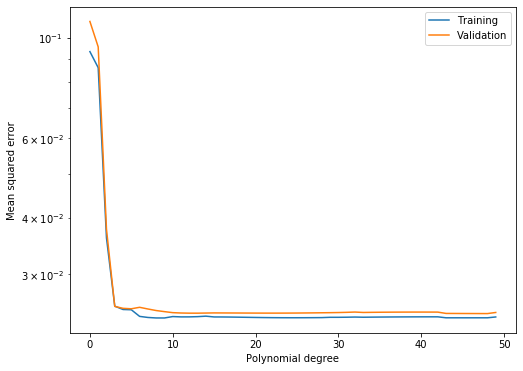

In [4]:
iterating_over_degree(x,y,50)

In [5]:
#def iterating_over_lambda (x, y, deg, MAXlambda):
def iterating_over_lambda (x, y, deg, MINlambda, MAXlambda):


    err_train = []
    err_cv = []
    
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3,random_state=10)

    for lam in np.logspace(MINlambda,MAXlambda,100):
        
        Poly = PolynomialFeatures(degree = deg)
        X_train_poly = Poly.fit_transform(x_train.reshape(-1,1))
        X_test_poly = Poly.fit_transform(x_test.reshape(-1,1))

        # fit model
        model_L2 = Ridge(alpha = lam, normalize = True, solver = 'lsqr') # select least squares regression as solver
        model_L2.fit(X_train_poly, y_train)
        prediction = model_L2.predict(X_test_poly)

        # compute errors
        err_train.append(mean_squared_error(model_L2.predict(X_train_poly), y_train))
        err_cv.append(mean_squared_error(model_L2.predict(X_test_poly), y_test))



    plt.figure(figsize = (8,6))
    plt.loglog(np.logspace(MINlambda,MAXlambda,100), err_train, np.logspace(MINlambda,MAXlambda,100), err_cv)
    plt.legend(["Training", "Validation"])
    plt.xlabel("$\lambda$ (or alpha in scikit learn terms)")
    plt.ylabel("Mean squared error")
    plt.show()

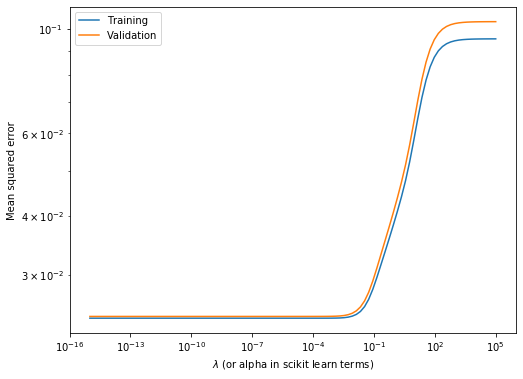

In [6]:
iterating_over_lambda(x,y,10,-15,5)

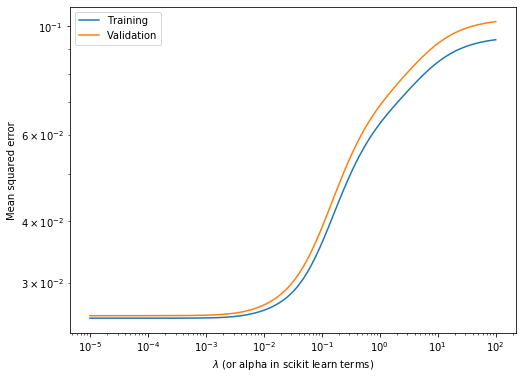

In [7]:
iterating_over_lambda(x,y,3,-5,2)

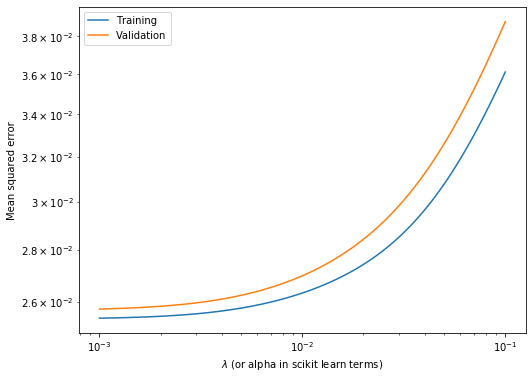

In [8]:
iterating_over_lambda(x,y,3,-3,-1)

In [9]:
#x1 = np.array(df["High_temp"])
#x2 = np.array(df["Avg_temp"])
#y = df["MAX"].values
#x = np.array([x1, x2])
#x 


#PF = PolynomialFeatures(degree = 4,interaction_only = False, include_bias = True)
#X_Poly = PF.fit_transform(x.reshape(-1,1))
#print(X_Poly)

In [21]:
def plot_regression_poly_scikit(x,y,deg, lam):
    
    Poly = PolynomialFeatures(degree = deg)
    X_poly = Poly.fit_transform(x.reshape(-1,1))

    model_L2 = Ridge(alpha = lam, normalize = True, solver = 'lsqr') # select least squares regression as solver
    model_L2.fit(X_poly, y)
    prediction = model_L2.predict(X_poly)
    
    # Plotting the regression line and the data (we have to transform the inputs as well!)
    x_fit = np.arange(x.min(),x.max() ,1)[:, np.newaxis]
    y_pred = model_L2.predict(Poly.fit_transform(x_fit.reshape(-1,1)))
    
    plt.figure(figsize = (8,6))
    plt.scatter(x,y,marker="x", c='C2')
    ylim = plt.ylim()
    plt.plot(x_fit,y_pred, c='C1')
    plt.xlabel("Temperature (°C)")
    plt.ylabel("Demand (GW)")
    plt.xlim([x.min()-2,x.max()+2]) # leave some space before and after limits
    plt.ylim(ylim)
    print ('The R^2 for quadratic curve is: ',r2_score(y, prediction))
    #print(lin_reg_Poly.coef_)

The R^2 for quadratic curve is:  0.7302971409168495


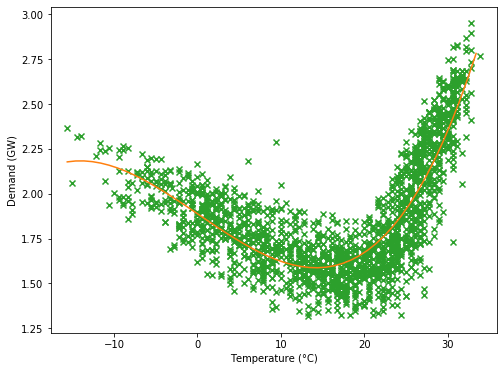

In [22]:
plot_regression_poly_scikit(x.T, y, 3, 0.01)

As we have discussed in last week's lecture it is advisable to actually do a three-ways split of the dataset to avoid leakage. You would typically do the following:

1. Divide data into training
set, holdout set, and test
set
2. Train algorithm on training
set (i.e., to learn
parameters), use holdout
set to select
hyperparameters
3. (Optional) retrain system
on training + holdout
4. Evaluate performance on
test set

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(xp, yp, test_size=0.3,random_state=34 )
X_train, X_hold, y_train, y_hold = train_test_split(X_train, y_train, test_size=(0.2/0.7),random_state=34 )


In [24]:
marburg = pd.read_pickle("../0_data/marburg_clean.pkl")
duisburg = pd.read_pickle('../0_data/duisburg_clean.pkl')
marburg_weather = pd.read_pickle("../0_data/weather/marburg_weather.pkl")
duisburg_weather = pd.read_pickle("../0_data/weather/duisburg_weather.pkl")

## Marburg

In [34]:
# peak demand
ym = marburg.resample('H').count()["day"]
# day of year
xm = ym.index.map(lambda datetime : datetime.dayofyear)

In [35]:
iterating_over_degree(xm,ym,50)

AttributeError: 'Int64Index' object has no attribute 'reshape'